In [1]:
%load_ext autoreload
%autoreload 2

In [91]:
from src.evaluation.scripts import multi_system_evaluation, load_system

BASE_PATH = '/home/al826/rds/hpc-work/2023/comparative/generate/output_text'
system = 'flant5-xl'
mode = 'comp-probs'  #comp-probs, scoring
dataset='wi-dev'

prompt_nums = [1, 2, 3, 4]
if dataset == 'summeval':
    SCORES = ['coherency', 'consistency', 'fluency', 'relevance'] 
elif dataset == 'topicalchat':
    SCORES = ['coherency', 'continuity', 'engagingness', 'naturalness']
elif dataset == 'wi-dev':
    SCORES = ['overall'] 
    prompt_nums = [1, 2]

for score_type in SCORES:
    paths = [f"{BASE_PATH}/{dataset}/{system}/{score_type}/{mode}-{i}/outputs/combined.json" for i in prompt_nums] #[1, 2, 3, 4]
    out = multi_system_evaluation(paths, dataset=dataset, score_type=score_type, balanced=False)

    for k in out['means'].keys():
        #if k in ['sys_spear', 'spear']:
        if k in ['spear']:
            #print(f" & {out['means'][k]:.1f}\std{{{out['stds'][k]:.1f}}}", end='')
            print(f" & {out['means'][k]:.1f}", end='')

 & 40.2

<AxesSubplot: xlabel='labels', ylabel='wins'>

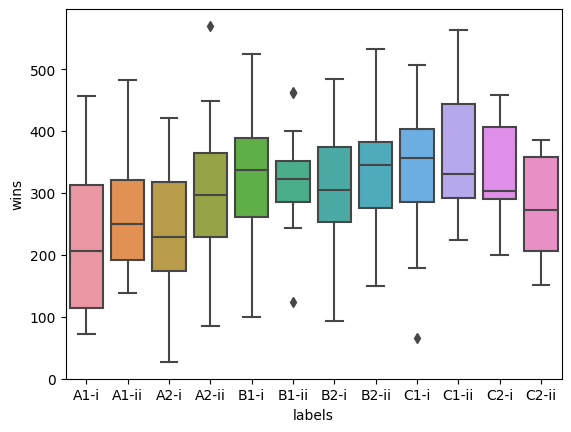

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from src.evaluation.scripts import load_system
from src.evaluation.eval_tools import Evaluater

i = 1
score_type = 'overall'


path = f"{BASE_PATH}/{dataset}/{system}/{score_type}/{mode}-{i}/outputs/combined.json"
sys = load_system(path)

ratings = sys.ratings
labels = Evaluater.load_ratings_labels(dataset=dataset, score_type=score_type)

#[['A', 'B', 'C'] ['1', '2'] ['i', 'ii']]
headers = itertools.product(*[['A', 'B', 'C'], ['1', '2'], ['-i', '-ii']])
headers = sorted([''.join(x) for x in headers])
lab_to_cefr = {k:v for k, v in enumerate(headers)}

y_preds = [v for k, v in sorted(ratings[0].items()) if k!=262]
y_labels = [lab_to_cefr[v] if v < 10 else lab_to_cefr[v-1] for k, v in sorted(labels[0].items()) if k!=262]

# sort into labels, to look at distributions
# out = defaultdict(list)
# for lab, pred in zip(y_labels, y_preds):
#     out[lab].append(pred)


df = pd.DataFrame({'labels':y_labels, 'wins':y_preds})
df = df.sort_values(by=['labels'])

sns.boxplot(data=df, x="labels", y="wins")
#plt.scatter(y_labels, y_preds)

In [116]:
from src.comparative.tools import comparatisons_to_tensors

sys = load_system(path)
C, M = comparatisons_to_tensors(sys.comparisons)
C = C[0]
M = M[0]

In [154]:
from src.comparative.tools import generate_mask_tensor, win_ratio

M_sel = generate_mask_tensor(N=300, num_comp=1000, num_contexts=1, mode='random')[0]
M_new = M * M_sel

scores = win_ratio(C, M_new)
scores_dict = {k:v for k, v in enumerate(scores)}
labels = Evaluater.load_ratings_labels(dataset='wi-dev', score_type='overall')
labels = [v for k, v in sorted(labels[0].items())]

In [ ]:
import scipy
from collections import defaultdict

def get_rand_comp_perf(C, M, x_axis, mode='random'):
    means, stds = [], []
    for R in x_axis:
        print(R)
        R_perf = []
        while len(R_perf) < 100:
            M_sel = generate_mask_tensor(N=300, num_comp=R, num_contexts=1, mode=mode)[0]
            M_new = M * M_sel

            scores = win_ratio(C, M_new)
            scores_dict = {k:v for k, v in enumerate(scores)}
            labels = Evaluater.load_ratings_labels(dataset='wi-dev', score_type='overall')
            labels = [v for k, v in sorted(labels[0].items())]

            spear = scipy.stats.spearmanr(scores, labels)[0]  

            if not np.isnan(spear):
                R_perf.append(spear)

        mean = np.mean(R_perf)
        std = np.std(R_perf)

        means.append(mean)
        stds.append(std)
        print(mean)
    return means, stds


x_axis = np.arange(300*4, 300*299+1, 300*5)
means, stds = get_rand_comp_perf(C, M, x_axis)

1200
0.19499470474165842
2700
0.2457979165470408
4200
0.2653084631285371
5700
0.2710655362301954
7200
0.2836550039769946
8700
0.2898137530976841
10200
0.2920702698968933
11700
0.29781096585785527
13200
0.2949206073741663
14700
0.29634625123746167
16200
0.29817449234529947
17700
0.2993457149710012
19200
0.3021702220094848
20700
0.3024785975188207
22200
0.3011751149852109
23700
0.301418065301811
25200
0.30400337703105246
26700
0.304556063940712
28200
0.3060108925956167
29700
0.3057586466573779
31200
0.30550402494768114
32700
0.30487072205248084
34200
0.30560471065553435
35700
0.30549380788391106
37200
0.3074253908561478
38700
0.30929879664415905
40200
0.3097806790675727
41700
0.30806287269558486
43200
0.30910828225124753
44700
0.3096200086018764
46200
0.3088728205834438
47700
0.3099468268336013
49200
0.3086031731958973
50700
0.3096044152482947
52200
0.3091788891886403
53700
0.3095440368635482
55200
0.30889698905510843
56700
0.30945825078935874
58200
0.3097360996682223
59700
0.30977120875

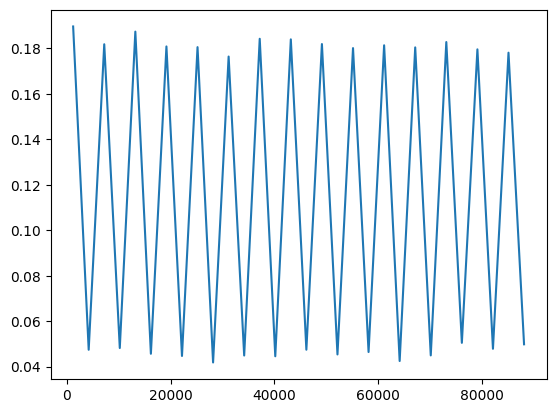

In [166]:
import matplotlib.pyplot as plt

x_axis = np.arange(300*4, 300*299+1, 300*10)

plt.plot(x_axis, output[-30:])

In [126]:
def win_ratio(C, M):  
    C = C*M  
    M = M + M.T
    print(C.shape)
    print(M.shape)
    x = np.sum(C, axis=1)/np.sum(M, axis=1)
    return x

scores = win_ratio(C, M_new)


(1, 300, 300)
(300, 300, 300)


/tmp/ipykernel_17335/834250874.py:6: RuntimeWarning: invalid value encountered in divide
  x = np.sum(C, axis=1)/np.sum(M, axis=1)


In [110]:
np.sum(M, axis=1)

array([[299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 299., 299., 299., 299., 299., 299.,
        299., 299., 299., 299., 299., 